<a href="https://colab.research.google.com/github/issa-project/issa-pipeline/blob/main/notebooks/issa-entity-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Named Entities in ISSA dataset

**Analysing quality of named entities found in the document text**  

Use cases: Agritrop, HAL Euromov DHM

Endpoints: https://data-issa.cirad.fr/sparql , 

In [1]:
import os
try:
    isColab = os.environ['GCE_METADATA_TIMEOUT']
    if isColab:
        !pip install SPARQLWrapper
except:
    pass

In [2]:
import pandas as pd
import json

from SPARQLWrapper import SPARQLWrapper, JSON

import matplotlib.pyplot as plt

import time

In [224]:
def sparql_service_to_dataframe(service, query):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

def sparql_service_to_dataframe_with_scrollable_cursor(service, query_templ, page_size=10000):
    offset= 0
    keep_going=True
    df_res_list = [] 

    print(service)
    print('fetching... ', end='')
    try:
        while True:
            query = query_templ % (offset, page_size) 
            #print(query)
            df_res = sparql_service_to_dataframe(service, query )
            if df_res.shape[0] > 0 : 
                print(df_res.shape[0], end=', ')
                df_res_list.append(df_res)
                offset = offset + page_size
                time.sleep(5)
            else:
                print(df_res.shape[0])
                df_res_list.append(df_res)
                break
    except Exception as ex:
        print(ex)
    finally:
        
        return pd.concat(df_res_list) if df_res_list else pd.DataFrame()

def hyperlink(val):
    return '<a href="{}">{}</a>'.format(val,val)

def hyperlink_multi(val):
    uris = val.split(', ')
    uris_hl = ['<a href="{}">{}</a>'.format(v,v) for v in uris]

    return ', '.join(uris_hl)

In [238]:
issa_instances = {'agritrop': {'endpoint' : 'https://data-issa.cirad.fr/sparql',
                               'namespace' : 'http://data-issa.cirad.fr/',
                               'name': 'issa-agritrop',
                              },
                  'hal':      {'endpoint' : 'http://localhost:8891/sparql',
                               'namespace' : 'http://data-issa.dhm.euromov.fr/',
                               'name': 'issa-hal-euromov-dhm',
                              }
                 }

instance='agritrop'

#issa_instances[instance]['endpoint'] = 'http://data-issa.cirad.fr/sparql'
#issa_instances[instance]['endpoint'] = issa_instances[instance]['endpoint']

## Dataset info

In [239]:
ns= issa_instances[instance]['namespace']
ds= issa_instances[instance]['name']

dataset_info_query = f'''
PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void: <http://rdfs.org/ns/void#> 
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX prov: <http://www.w3.org/ns/prov#>


SELECT * 
FROM <{ns}graph/dataset>
WHERE {{
  VALUES (?dataset) {{ (<{ns}{ds}>) }}
  
  ?datatest dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:generatedAtTime ?generated_date.
  
  OPTIONAL{{ ?dataset dct:modified ?updated_date. }}
}} 
'''
print(dataset_info_query)


PREFIX rdf:  <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void: <http://rdfs.org/ns/void#> 
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX prov: <http://www.w3.org/ns/prov#>


SELECT * 
FROM <http://data-issa.cirad.fr/graph/dataset>
WHERE {
  VALUES (?dataset) { (<http://data-issa.cirad.fr/issa-agritrop>) }
  
  ?datatest dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:generatedAtTime ?generated_date.
  
  OPTIONAL{ ?dataset dct:modified ?updated_date. }
} 



In [240]:
dataset_info = sparql_service_to_dataframe(issa_instances[instance]['endpoint'], dataset_info_query)
dataset_info.transpose()

,0
dataset,http://data-issa.cirad.fr/issa-agritrop
datatest,http://data-issa.cirad.fr/issa-agritrop
dataset_name,ISSA Agritrop dataset
dataset_description,This RDF dataset was produced by processing articles from Agritrop - the open repository of CIRA...
triple_count,131494758
version,2.0.20231002
initial_date,2022-04-29
generated_date,2023-10-19
updated_date,2023-10-19


## Count named entities from all NER tools

In [235]:
ns=issa_instances[instance]['namespace']

entity_count_per_annotator_query = f'''
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX issa:   <{ns}>
PREFIX prov: <http://www.w3.org/ns/prov#>


SELECT ?annotator 
       (count(?entity) as ?cnt) 
	     (count(distinct ?uri) as ?unique_cnt)
FROM <{ns}graph/dbpedia-spotlight-nes>
FROM <{ns}graph/entity-fishing-nes>
FROM <{ns}graph/geographic-nes>
FROM <{ns}graph/pyclinrec-nes>
WHERE {{
	?entity a prov:Entity;
          oa:hasBody ?uri;
          prov:wasAttributedTo ?annotator.
}}
''' 
print(entity_count_per_annotator_query)


PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>


SELECT ?annotator 
       (count(?entity) as ?cnt) 
	     (count(distinct ?uri) as ?unique_cnt)
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
WHERE {
	?entity a prov:Entity;
          oa:hasBody ?uri;
          prov:wasAttributedTo ?annotator.
}



In [236]:
df_entity_count = sparql_service_to_dataframe(issa_instances[instance]['endpoint'], entity_count_per_annotator_query)

df_entity_count = df_entity_count.astype({'cnt': 'int',
                                          'unique_cnt' : 'int'})

print(df_entity_count.shape)

(4, 3)


In [237]:
table_style = [{"selector": "", "props": [("border", "3px solid lightblue !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]
               
df_entity_count.style.set_table_styles(table_style)

,annotator,cnt,unique_cnt
0,http://data-issa.cirad.fr/EntityFishing,2089176,68033
1,http://data-issa.cirad.fr/GeographicEntityExtractor,225553,8130
2,http://data-issa.cirad.fr/Pyclinrec,3431727,17204
3,http://data-issa.cirad.fr/DBPediaSpotlight,1907910,74421


## Annotation quality assesment per vocabulary
Select one of the vocabularis and run the cells below

In [194]:
annotators = {'wikidata': 'issa:EntityFishing',
              'geonames': 'issa:GeographicEntityExtractor',
              'dbpedia' : 'issa:DBPediaSpotlight',
              'agrovoc' : 'issa:Pyclinrec'}

In [195]:
# in some queries having a long choice of paths to a label proves to be too expensive. 
# For these queries we can split the path and pass it as a string substitution.
label_path = {'wikidata': 'rdfs:label|skos:prefLabel|dct:title|schema:name',
              'geonames': 'gn:officialName',
              'dbpedia' : 'rdfs:label|skos:prefLabel|dct:title|schema:name',
              'agrovoc' : 'skosxl:prefLabel/skosxl:literalForm'}

In [153]:
instance='agritrop'
vocab = 'dbpedia'

### Count number of annottaions per entity

In [197]:
ns=issa_instances[instance]['namespace']
annotator=annotators[vocab]

annotations_per_entity_count_query = f'''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <{ns}graph/dbpedia-spotlight-nes>
FROM <{ns}graph/entity-fishing-nes>
FROM <{ns}graph/geographic-nes>
FROM <{ns}graph/pyclinrec-nes>
FROM <{ns}graph/dbpedia-named-entities>
FROM <{ns}graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {{

      SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
      WHERE {{

      {{
      SELECT ?uri ?annotator
            (count(distinct ?paper) as ?cnt)
            (min(?conf) as ?min_conf)
            (max(?conf) as ?max_conf)

      WHERE {{
            ?entity a prov:Entity;
            oa:hasBody ?uri;
            schema:about ?paper;
            issapr:confidence ?conf;
            prov:wasAttributedTo ?annotator.
            FILTER (?annotator = {annotator}) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec
            }}
      GROUP by  ?uri ?annotator
      }}
      
      OPTIONAL {{
            ?uri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }}
      # for DBPedia.fr
      OPTIONAL {{
            ?uri rdfs:label ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }}
      # for Geonames
      OPTIONAL {{
            # |gn:alternateName||gn:shortName
            ?uri gn:name ?entityLabel_nolang.
      }}
      
            BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
      }}
      ORDER BY DESC(?cnt)
}}
OFFSET %d
LIMIT  %d
'''

print(annotations_per_entity_count_query)


PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>


In [198]:
df_ne_count = {}
#for key, value in annotators.items():
key, value = vocab, annotators[vocab]
df_ne_count[key] = sparql_service_to_dataframe_with_scrollable_cursor(issa_instances[instance]['endpoint'],
                                                                      annotations_per_entity_count_query )
#df_ne_count[key].dropna(inplace=True)
df_ne_count[key] = df_ne_count[key].astype({'cnt': 'int',
                                            'min_conf' : 'float',
                                            'max_conf' : 'float'})
print(instance, vocab)
print(annotators[key] , df_ne_count[key].shape)

https://data-issa.cirad.fr/sparql
fetching... 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.o

10000, 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/

4425, 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

SELECT ?uri ?entityLabel ?cnt ?min_conf ?max_conf
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/g

In [14]:
#import pickle
#with open('df_ne_count.pkl', 'wb') as f:
#    pickle.dump(df_ne_count, f)

#with open('df_ne_count.pkl', 'rb') as f:
#    df_ne_count = pickle.load(f)

In [200]:
print(vocab)
df_ne_count[vocab].describe() \
                  .transpose() \
                  .style.format(precision=2)\
                  .set_table_styles(table_style) 

dbpedia


,count,mean,std,min,25%,50%,75%,max
cnt,74425.00,10.97,54.97,1.00,1.00,2.00,5.00,3367.00
min_conf,74425.00,0.98,0.06,0.75,1.00,1.00,1.00,1.00
max_conf,74425.00,0.99,0.03,0.75,1.00,1.00,1.00,1.00


OBSERVATIONS: 
- AGROVOC: Confidence score is always 1.0. It should be addressed in the *pyclinrec* library
- GEONAMES: the confidence scores can be low for the GeoNames named entities because we are trying to annotate a short text 
- WIKIDATA: by default the entity-fishing returns NE with conf 0.25 for French and 0.35 for English
- DBPEDIA: we do filter the DBpedia NEs by setting up the Spotlight parameters, therefore the min confidence is 0.75. Otherwise there would be a lot of NEs

### Most popular entities 

In [201]:
df_ne_count[vocab].head()

,uri,entityLabel,cnt,min_conf,max_conf
0,http://dbpedia.org/resource/Species,Species,3367,0.750110,1.00000
1,http://fr.dbpedia.org/resource/Eau,Eau,3040,0.751543,1.00000
2,http://fr.dbpedia.org/resource/France,France,2534,0.770031,1.00000
3,http://fr.dbpedia.org/resource/Agriculture,Agriculture,2468,0.751821,1.00000
4,http://fr.dbpedia.org/resource/Élevage,Élevage,2404,0.976587,0.97703


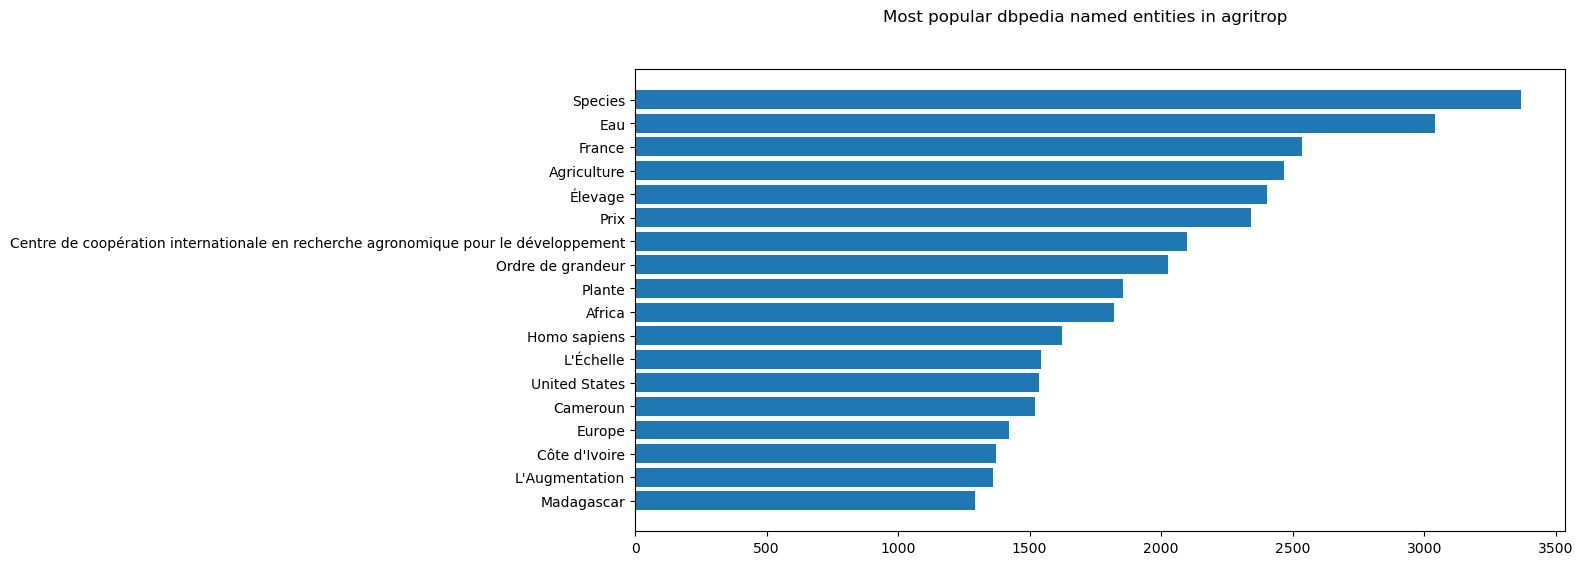

In [202]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle(f'Most popular {vocab} named entities in {instance}')

plt.barh(df_ne_count[vocab].head(20).entityLabel , width= df_ne_count[vocab].head(20).cnt)
plt.gca().invert_yaxis()

plt.show()

OBSERVATIONS: 
- AGROVOC: top named entities are general concepts
- GEONAMES: as expected 
- WIKIDATA: as expected the top named entities are either geographic or agriculture related.
- DBPEDIA: as expected

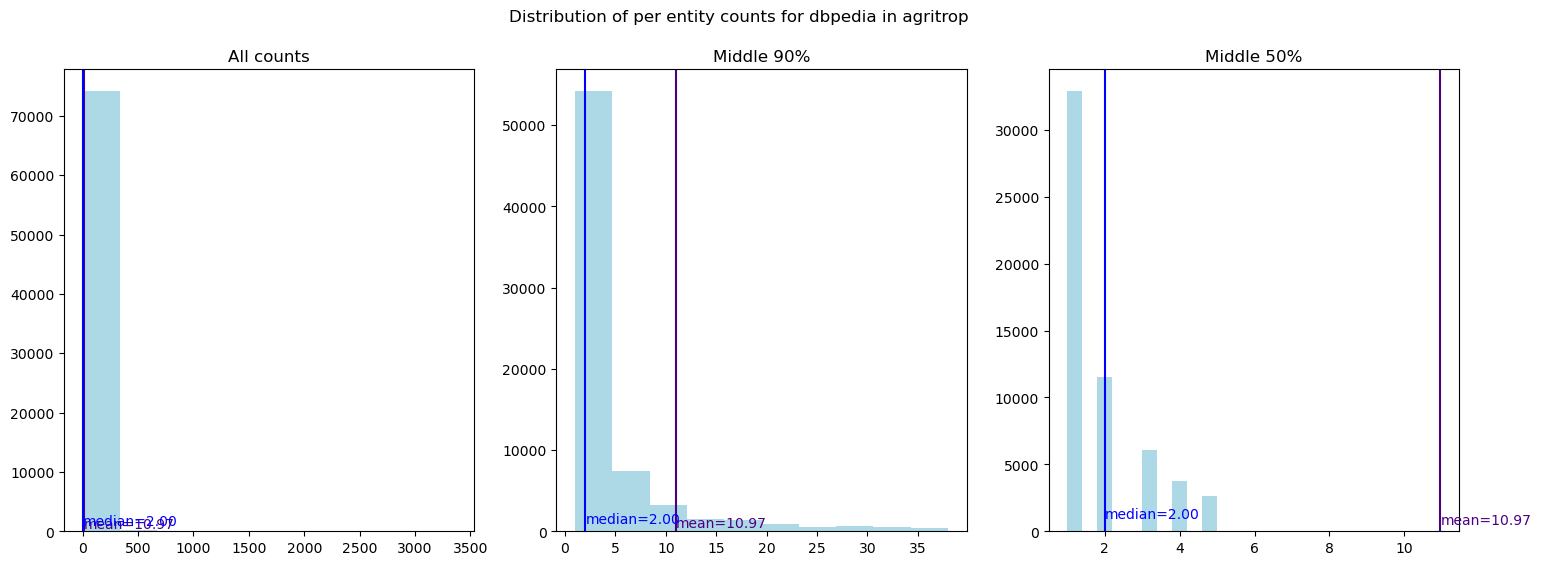

In [203]:
fig = plt.figure(figsize=(18, 6))
fig.suptitle(f'Distribution of per entity counts for {vocab} in {instance}')

def show_hist(i, df_f1, range=None, title=None):
    mean_cnt = df_f1.cnt.mean()
    median_cnt = df_f1.cnt.median()

    plt.subplot(1 , 3, i+1)

    plt.hist(df_f1.cnt, 10, color='lightblue', range=range )
    plt.axvline(mean_cnt, color='indigo')
    plt.text(mean_cnt + 0.01, 500, 'mean=%.2f' % mean_cnt , color="indigo")

    plt.axvline(median_cnt, color="blue")
    plt.text(median_cnt + 0.01, 1000, 'median=%.2f' % median_cnt , color="blue")
    
    plt.title(title)


show_hist(0, df_ne_count[vocab], title='All counts')
show_hist(1, df_ne_count[vocab], range=(df_ne_count[vocab].cnt.quantile(0.05) ,  
                                        df_ne_count[vocab].cnt.quantile(0.95)),
          title='Middle 90%' )
show_hist(2, df_ne_count[vocab], range=(df_ne_count[vocab].cnt.quantile(0.25) ,
                                        df_ne_count[vocab].cnt.quantile(0.75)),
         title='Middle 50%')

### Missing labels

In [204]:
print(instance, vocab)   
print(df_ne_count[vocab][df_ne_count[vocab].entityLabel.isna()].shape)

df_ne_count[vocab][df_ne_count[vocab].entityLabel.isna()]\
    .head()\
    .style.format({'uri': hyperlink})

agritrop dbpedia
(85, 5)


,uri,entityLabel,cnt,min_conf,max_conf
4474,http://fr.dbpedia.org/resource/Solagro,None,31,1.000000,1.000000
5322,http://fr.dbpedia.org/resource/The_Wood,None,26,1.000000,1.000000
8676,http://dbpedia.org/resource/Ks_ratio,None,14,1.000000,1.000000
9388,http://fr.dbpedia.org/resource/Mbombela,None,13,1.000000,1.000000
3714,http://fr.dbpedia.org/resource/Sunrise_UPC,None,8,0.839959,1.000000


OBSERVATIONS: 
- AGROVOC: no missing values! :thumbup
- GEONAMES: some GeonamesID in Wikidata are obsolete. For ex. 8505035 for Yuogoslavia.  
- WIKIDATA: investigate why 322 entities do not have labels
- DBPEDIA: Cannot retrieve labels for 85 entities because the labels are not defined in their respective DBPedia instances.

### Named entities recognised from a short word ( surface <= 3 characters)

In [163]:
ns=issa_instances[instance]['namespace']
annotator=annotators[vocab]
slen = '< 4'
lpath =label_path[vocab]

short_text_query = f'''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX issa:   <{ns}>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>
PREFIX issapr:  <{ns}property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <{ns}graph/dbpedia-spotlight-nes>
FROM <{ns}graph/entity-fishing-nes>
FROM <{ns}graph/geographic-nes>
FROM <{ns}graph/pyclinrec-nes>
FROM <{ns}graph/dbpedia-named-entities>
FROM <{ns}graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {{
      {{SELECT ?surface ?entityUri (count(?surface) as ?cnt) (max(?surfaceLEN) as ?surfaceLen)
      WHERE {{
            #VALUES (?entity) {{(<{ns}ann/00006684522793ef568fee34752ac6371f33d3c3>)}}
            ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  issapr:confidence ?conf;
                  prov:wasAttributedTo ?annotator.
            FILTER (?annotator = {annotator}) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

            ?selector oa:exact ?surface;
                  oa:start ?start.

            BIND ( STRLEN(?surface) as ?surfaceLEN )
            FILTER ( ?surfaceLEN {slen} )
            }} 
      GROUP BY ?surface ?entityUri ?entityLabel
      }}
      OPTIONAL {{
            #?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel.
            ?entityUri {lpath} ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }}
      OPTIONAL {{
            ?entityUri {lpath} ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }}
      # for Geonames
      #OPTIONAL {{
      #      ?entityUri gn:name ?entityLabel_nolang.
      #}}

      BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
}}
ORDER BY ?surface ?entityLabel
'''

In [205]:
df_short_text_count = {}

df_short_text_count[vocab] = sparql_service_to_dataframe(issa_instances[instance]['endpoint'],  short_text_query)
df_short_text_count[vocab] = df_short_text_count[vocab].astype({'cnt': 'int',
                                                                'surfaceLen': 'int'})
print(instance, vocab)   
print(annotators[vocab] , df_short_text_count[vocab].shape)

agritrop dbpedia
issa:DBPediaSpotlight (8205, 7)


#### len(surface) == 1

In [206]:
print(instance, vocab)
print(df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 1].shape)
df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 1]\
                          .sort_values(by=['entityLabel_en','cnt'])\
                  #.style.set_table_styles(table_style)

agritrop dbpedia
(0, 7)


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt


OBSERVATIONS: 
- AGROVOC: filtering of surface >= 3 in effect :thumbsup
- GEONAMES: filtering of surface >= 2 in effect :thumbsup
- WIKIDATA:  filtering surface string >= 3 in effect :thumbsup
- DBPEDIA: filtering surface string >= 3 in effect :thumbsup

#### len(surface) == 2

In [207]:
print(instance, vocab)
print(df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 2].shape)
df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 2]\
                          .sort_values(by=['cnt'], ascending=False)\
                  #.style.format({'entityUri': hyperlink})

agritrop dbpedia
(0, 7)


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt


CONCLUSION: 
- AGROVOC: the 2 letter surface also does not match very well with the exceptions of UK, EU, and pH. I think they should be filtered as well (0.4% of all) => filtering surface string >= 3 in effect
- GEONAMES: the most popular 2 letter entities look like legit abbreviations, e.g.  *UK* or *US*. 
- WIKIDATA: filtering surface string >= 3 is in effect :thimbsup
- DBPEDIA: filtering surface string >= 3 is in effect :thimbsup

#### len(surface) == 3

In [208]:
print(instance, vocab)
pd.options.display.max_rows = 100
df_short_text_count[vocab].loc[df_short_text_count[vocab].surfaceLen == 3]\
                          .sort_values(by=['cnt', 'entityLabel_en'], ascending=False)\
               .head()
               #.style.format({'entityUri': hyperlink})


agritrop dbpedia


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt
6712,3,eau,None,Eau,Eau,http://fr.dbpedia.org/resource/Eau,12280
7732,3,riz,None,Riz,Riz,http://fr.dbpedia.org/resource/Riz,4039
4264,3,PCR,Polymerase chain reaction,None,Polymerase chain reaction,http://dbpedia.org/resource/Polymerase_chain_reaction,2720
1452,3,DNA,DNA,None,DNA,http://dbpedia.org/resource/DNA,2376
5874,3,USA,United States,None,United States,http://dbpedia.org/resource/United_States,1979


OBSERVATIONS: 
- AGROVOC: for the populous 3 letter words the annotation is pretty accurate. For less popular words and abbreviations it's hard to tell without the context
- GEONAMES: Lot's of abbreviations for geographical entities with 3 letters. We should keep them  
- WIKIDATA: hard to tell. some of the 3 letter entities look ok, like *CWD* (Coffee Wilt Disease). Definetely needs a closer look.
- DBPEDIA: hard to tell. some of the 3 letter entities look ok, like *USA* (United States) or *DNA*.  

### Surface forms that begin with non-letters

In [209]:
ns=issa_instances[instance]['namespace']
annotator=annotators[vocab]
lpath =label_path[vocab]

text_starts_with_non_letter_query = f''' 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <{ns}graph/dbpedia-spotlight-nes>
FROM <{ns}graph/entity-fishing-nes>
FROM <{ns}graph/geographic-nes>
FROM <{ns}graph/pyclinrec-nes>
FROM <{ns}graph/dbpedia-named-entities>
FROM <{ns}graph/wikidata-named-entities>
FROM <http://geonames.org/graph>
FROM <http://agrovoc.fao.org/graph>
WHERE {{
      {{SELECT ?surface ?entityUri (count(?surface) as ?cnt) (max(?surfaceLEN) as ?surfaceLen)
      WHERE {{
            #VALUES (?entity) {{(<{ns}ann/00006684522793ef568fee34752ac6371f33d3c3>)}}
            ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  issapr:confidence ?conf;
                  prov:wasAttributedTo ?annotator.
            FILTER (?annotator = {annotator}) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

            ?selector oa:exact ?surface;
                  oa:start ?start.

            BIND ( STRLEN(?surface) as ?surfaceLEN )
            FILTER ( ! REGEX(?surface, "^[a-z,A-Z,À-ÿ]")  ) # Greek letters ,\\p{{Greek}},µ
            }} 
      GROUP BY ?surface ?entityUri ?entityLabel
      }}
      OPTIONAL {{
            #?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel.
            ?entityUri {lpath} ?entityLabel_en.
            FILTER langMatches(lang(?entityLabel_en), "en" )
      }}
      OPTIONAL {{
            ?entityUri {lpath} ?entityLabel_fr.
            FILTER langMatches(lang(?entityLabel_fr), "fr" )
      }}
      # for Geonames
      OPTIONAL {{
            ?entityUri gn:name ?entityLabel_nolang.
      }}

      BIND(COALESCE(?entityLabel_en, ?entityLabel_fr, ?entityLabel_nolang) as ?entityLabel)
}}
ORDER BY ?surface ?entityLabel
'''
print(text_starts_with_non_letter_query)

 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

SELECT ?surfaceLen ?surface ?entityLabel_en ?entityLabel_fr ?entityLabel ?entityUri ?cnt 
FROM <http://data-issa.cirad.fr/graph/dbpedia-spotlight-nes>
FROM <http://data-issa.cirad.fr/graph/entity-fishing-nes>
FROM <http://data-issa.cirad.fr/graph/geographic-nes>
FROM <http://data-issa.cirad.fr/graph/pyclinrec-nes>
FROM <http://data-issa.cirad.fr/graph/dbpedia-named-entities>
FROM <http://data-issa.cirad.fr/graph/wikidata-named-entities>
FROM <http://geonames.org/gr

In [210]:
df_non_letter_count = {}

df_non_letter_count[vocab] = sparql_service_to_dataframe(issa_instances[instance]['endpoint'],  text_starts_with_non_letter_query)
df_non_letter_count[vocab] = df_non_letter_count[vocab].astype({'cnt': 'int',
                                                                'surfaceLen': 'int'})
print(instance, vocab)   
print(annotators[vocab] , df_non_letter_count[vocab].shape)

agritrop dbpedia
issa:DBPediaSpotlight (0, 7)


In [211]:
print(instance, vocab)
df_non_letter_count[vocab].sort_values(by=['surface'])\
                  #.style.format({'entityUri': hyperlink})
                  

agritrop dbpedia


,surfaceLen,surface,entityLabel_en,entityLabel_fr,entityLabel,entityUri,cnt


OBSERVATIONS:
- AGROVOC: filtering out of non-letters beginings of the text is in effect
- GEONAMES: filtering out of non-letters beginings of the text is in effect
- WIKIDATA: filtering out of non-letters beginings of the text is in effect in most part. We should add a curly bracket to the set of non-alphabet characters. But the unit entities taht begin with  µ should stay.
- DBPEDIA: filtering out of non-letters beginings of the text is in effect



### Multiple named entities for one surface form

In [212]:
ns=issa_instances[instance]['namespace']
annotator=annotators[vocab]
lpath =label_path[vocab]
ecnt='> 1'

multiple_entities_query = f'''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <{ns}>

SELECT ?source ?surface ?start ?cnt 
       #?entities 
WHERE {{
  {{ SELECT ?source ?surface ?start 
          (count(?entityUri) as ?cnt)
          (group_concat(?entityUri; separator=", ") as ?entities) 
    WHERE {{
          #VALUES (?entity) {{(<{ns}ann/00006684522793ef568fee34752ac6371f33d3c3>)}}
          ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
                  prov:wasAttributedTo ?annotator.
          FILTER (?annotator = {annotator}) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

          ?selector oa:exact ?surface;
                    oa:start ?start.
          }} 
    GROUP BY ?source ?surface ?start
    HAVING ((count(?entityUri) {ecnt} ) )
  }}

}}
order by desc(?cnt)
'''

print(multiple_entities_query)


PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>

SELECT ?source ?surface ?start ?cnt 
       #?entities 
WHERE {
  { SELECT ?source ?surface ?start 
          (count(?entityUri) as ?cnt)
          (group_concat(?entityUri; separator=", ") as ?entities) 
    WHERE {
          #VALUES (?entity) {(<http://data-issa.cirad.fr/ann/00006684522793ef568fee34752ac6371f33d3c3>)}
          ?entity a prov:Entity;
                  oa:hasBody ?entityUri;       
                  oa:hasTarget/oa:hasSelector ?selector;
                  oa:hasTarget/oa:hasSource ?source;
           

In [213]:
pd.options.display.max_colwidth = 100

df_multi_entities = df_multi_entities if 'df_multi_entities' in locals() else {}

df_multi_entities[vocab] = sparql_service_to_dataframe(issa_instances[instance]['endpoint'],
                                                       multiple_entities_query)

df_multi_entities[vocab] = df_multi_entities[vocab].astype({'cnt': 'int'})

print(instance, vocab)   
print(annotators[vocab] , df_multi_entities[vocab].shape)

agritrop dbpedia
issa:DBPediaSpotlight (0, 4)


In [214]:
print(instance, vocab)
pd.options.display.max_rows = 10
df_multi_entities[vocab].sort_values(by=['cnt'], ascending=False)\
                        #.head()

agritrop dbpedia


,source,surface,start,cnt


OBSERVATIONS: 
- AGROVOC: The number of overlaping entities has been reduced by 10 folds by the new vesrion of pyclinrec. However, the problem with multuple entities for the surfaces with repetitive words still persist although to a lesser scale. More analysuis in the next few cells
- GEONAMES: no multiple NEs for the same surface form :thumbsup
- WIKIDATA: no multiple NEs for the same surface form :thumbsup
- DBPEDIA: no multiple NEs for the same surface form :thumbsup

#### detect repeated text 

Sometimes repeated string in the surface form creates multiple NEs

In [215]:
def detect_repeat(string_to_split):
    import re
    return pd.Series(re.split('-| ', string_to_split.lower())).value_counts().max() > 1

df_multi_entities[vocab]['repeat']  = df_multi_entities[vocab].surface.apply(detect_repeat)

print(instance, vocab)
df_multi_entities[vocab].loc[df_multi_entities[vocab].repeat]\
                        .sort_values(by=['cnt', 'surface'], ascending=False)\
                        .head()\
                        #.style.format({'source': hyperlink})

agritrop dbpedia


,source,surface,start,cnt,repeat


In [216]:
# non repeated text
print(instance, vocab)
pd.options.display.max_rows = 10
df_multi_entities[vocab].loc[df_multi_entities[vocab].repeat==False]\
                        .sort_values(by=['cnt', 'surface'], ascending=False)\
                        .head()\
                        #.style.format({'source': hyperlink})

agritrop dbpedia


,source,surface,start,cnt,repeat


In [185]:
# Complementary query: get all the entities for a specific text
# that raises a question

ns=issa_instances[instance]['namespace']
annotator=annotators[vocab]
doc = '593761'
start  = 655

entities_for_surface_query = f''' 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/> 

SELECT ?source ?start ?surface ?entityUri ?entityLabel_en ?entityLabel_fr
WHERE 
{{
    VALUES (?source) {{(<{ns}document/{doc}#body_text>)}}
    VALUES (?start) {{( {start} )}}
    
    ?entity a prov:Entity;
            oa:hasBody ?entityUri;       
            oa:hasTarget/oa:hasSelector ?selector;
            oa:hasTarget/oa:hasSource ?source;
            prov:wasAttributedTo ?annotator.
    FILTER (?annotator = {annotator})

    ?selector oa:exact ?surface;
              oa:start ?start.

    OPTIONAL {{
        ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_en.
        FILTER langMatches(lang(?entityLabel_en), "en" )  }}

	OPTIONAL {{
	    ?entityUri rdfs:label|skos:prefLabel|(skosxl:prefLabel/skosxl:literalForm)|dct:title|schema:name|gn:officialName|gn:alternateName|gn:name|gn:shortName ?entityLabel_fr.
        FILTER langMatches(lang(?entityLabel_fr), "fr" ) }}
}}
'''
print(entities_for_surface_query)

 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX schema: <http://schema.org/>
PREFIX gn:     <http://www.geonames.org/ontology#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

SELECT ?source ?start ?surface ?entityUri ?entityLabel_en ?entityLabel_fr
WHERE 
{
    VALUES (?source) {(<http://data-issa.cirad.fr/document/593761#body_text>)}
    VALUES (?start) {( 655 )}
    
    ?entity a prov:Entity;
            oa:hasBody ?entityUri;       
            oa:hasTarget/oa:hasSelector ?selector;
            oa:hasTarget/oa:hasSource ?source;
            prov:wasAttributedTo ?annotator.
    FILTER (?annotator = issa:DBPediaSpotlight)

    ?select

In [187]:
df_nes = sparql_service_to_dataframe(issa_instances[instance]['endpoint'],  entities_for_surface_query)

print(instance, vocab)
print(df_nes.shape)
df_nes

agritrop dbpedia
(0, 6)


,source,start,surface,entityUri,entityLabel_en,entityLabel_fr


### Overlaping Named Entities

In [218]:
ns=issa_instances[instance]['namespace']
annotator=annotators[vocab]
offset='%d'
limit='%d'

overlaping_na_query_templ  = f'''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX prov: <http://www.w3.org/ns/prov#>

PREFIX issa:   <{ns}>
PREFIX issapr: <{ns}property/> 

select ?source ?surface ?start ?end ?conf ?entityUri
               ?surface_ovlp ?start_ovlp ?conf_ovlp 
               ?entityUri_ovlp ?entity_ovlp
WHERE 
{{
  {{
    SELECT distinct ?annotator ?source ?surface ?start ?end ?conf ?entityUri
    WHERE {{
      ?entity a prov:Entity;
              oa:hasBody ?entityUri; 
              oa:hasTarget/oa:hasSelector ?selector;
              oa:hasTarget/oa:hasSource ?source;
              issapr:confidence ?conf;
              prov:wasAttributedTo ?annotator.
      FILTER (?annotator = {annotator} ) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

      ?selector oa:exact ?surface;
                        oa:start ?start.
      OPTIONAL {{ ?selector oa:end ?end_opt. }}
      BIND( COALESCE( ?end_, ?start + STRLEN(?surface)) AS ?end)

      FILTER(REGEX(?surface, "\\\\w+\\\\s+\\\\w+", "i")) # 2 or more words
      #FILTER(REGEX(?surface, "\\\\w+\\\\s+\\\\w+(\\\\s+\\\\w+)+", "i")) # 3 or more words
    }}
    OFFSET {offset}
    LIMIT {limit}
  }}
	?entity_ovlp a prov:Entity;
              oa:hasBody ?entityUri_ovlp;       
              oa:hasTarget/oa:hasSelector ?selector_ovlp;
              oa:hasTarget/oa:hasSource ?source;
              issapr:confidence ?conf_ovlp;
              prov:wasAttributedTo ?annotator.

      ?selector_ovlp  oa:exact ?surface_ovlp;
    					oa:start ?start_ovlp.
      OPTIONAL {{ ?selector_ovlp oa:end ?end_opt_ovlp. }} #this is important for wikidata
      BIND( COALESCE( ?end_opt_ovlp, ?start_ovlp + STRLEN(?surface_ovlp)) AS ?end_ovlp) 
                        
      FILTER ( ((?start_ovlp > ?start) && (?start_ovlp < ?end) ) ||
               ((?start_ovlp = ?start) && (?end_ovlp   < ?end)) )
}}
'''
print(overlaping_na_query_templ)


PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX prov: <http://www.w3.org/ns/prov#>

PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr: <http://data-issa.cirad.fr/property/> 

select ?source ?surface ?start ?end ?conf ?entityUri
               ?surface_ovlp ?start_ovlp ?conf_ovlp 
               ?entityUri_ovlp ?entity_ovlp
WHERE 
{
  {
    SELECT distinct ?annotator ?source ?surface ?start ?end ?conf ?entityUri
    WHERE {
      ?entity a prov:Entity;
              oa:hasBody ?entityUri; 
              oa:hasTarget/oa:hasSelector ?selector;
              oa:hasTarget/oa:hasSource ?source;
              issapr:confidence ?conf;
              prov:wasAttributedTo ?annotator.
      FILTER (?annotator = issa:DBPediaSpotlight ) # issa:EntityFishing | issa:DBPediaSpotlight | issa:GeographicEntityExtractor | issa:Pyclinrec

      ?selector oa:exact ?surface;
               

In [225]:
df_overlaping_ne = {}

df_overlaping_ne[vocab] = sparql_service_to_dataframe_with_scrollable_cursor(issa_instances[instance]['endpoint'],
                                                                             overlaping_na_query_templ, 
                                                                             page_size = 5000)
print(instance, vocab) 
print(df_overlaping_ne[vocab].shape)

https://data-issa.cirad.fr/sparql
fetching... 0
agritrop dbpedia
(0, 11)


In [227]:
print(instance, vocab)
df_overlaping_ne[vocab].groupby(by=['surface', 'surface_ovlp'])\
                       .count()\
                       .sort_values(by='source', ascending=False )\
                       .loc[:, ['source', 'start', 'end' ]]

agritrop dbpedia


,,source,start,end
surface,surface_ovlp,,,


In [228]:
print(instance, vocab)
df_overlaping_ne[vocab].groupby(by=['source'])\
                       .count()\
                       .sort_values(by='surface', ascending=False )\
                       .loc[:, ['surface', 'start', 'end' ]]

agritrop dbpedia


,surface,start,end
source,,,


#### starts with

In [231]:
starts_with = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab].apply(lambda r: r.surface.startswith(r.surface_ovlp), axis=1)]

print(instance, vocab)    
print(starts_with.shape )
starts_with.head()

ValueError: Cannot index with multidimensional key

#### ends with

In [84]:
ends_with = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                   .apply(lambda r: r.surface.endswith(r.surface_ovlp), axis=1)]
print(instance, vocab)    
print(ends_with.shape )
ends_with.head()

ValueError: Cannot index with multidimensional key

#### contains

In [85]:
contains = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                  .apply(lambda r: r.surface_ovlp in r.surface[1:-1], axis=1)]
print(instance, vocab)    
print(contains.shape )
contains.head()

ValueError: Cannot index with multidimensional key

#### partial overlap

In [86]:
partial_overlap = df_overlaping_ne[vocab].loc[df_overlaping_ne[vocab]\
                                        .apply(lambda r: r.surface_ovlp not in r.surface, axis=1)]

print(instance, vocab)    
print(partial_overlap.shape )
partial_overlap.head()

ValueError: Cannot index with multidimensional key

OBSERVATIONS:

- AGROVOC: pyclinrec recognise named entities in overlaping surface forms. All combinations are detected: the same begining, the same ending, one annotated text inside the other, or partially overlap.  ==> detecting and filtering overlaps before uploading to the graph solves this problem. 
- GEONAMES: no overalping :thumbsup
- WIKIDATA: no overalping :thumbsup
- DBPEDIA: DBPedia spotlight recognise named entities in overlaping surface forms. All combinations are detected: the same begining, the same ending, one annotated text inside the other, or partially overlap.==> detecting and filtering overlaps before uploading to the graph solves this problem. 